<a href="https://colab.research.google.com/github/nikhil-xyz/Imdb-Sentiment-Analysis/blob/main/Imdb_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
! git clone https://github.com/nikhil-xyz/Imdb-Sentiment-Analysis.git

fatal: destination path 'Imdb-Sentiment-Analysis' already exists and is not an empty directory.


In [94]:
import pandas as pd

In [95]:
data = pd.read_csv('/content/Imdb-Sentiment-Analysis/Train.csv')

In [96]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [97]:
data.shape

(40000, 2)

In [98]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [99]:
list(data.groupby('label'))

[(0,                                                     text  label
  0      I grew up (b. 1965) watching and loving the Th...      0
  1      When I put this movie in my DVD player, and sa...      0
  2      Why do people who do not know what a particula...      0
  3      Even though I have great interest in Biblical ...      0
  5      A terrible movie as everyone has said. What ma...      0
  ...                                                  ...    ...
  39984  I couldn't relate to this film. It failed to e...      0
  39985  Comedy? What's so funny about watching an ugly...      0
  39993  "The Best Movie of the 90's" "The Welsh Trains...      0
  39994  My girlfriend has the habit of going to Blockb...      0
  39997  My wife and I watched this movie because we pl...      0
  
  [20019 rows x 2 columns]),
 (1,                                                     text  label
  4      Im a die hard Dads Army fan and nothing will e...      1
  6      Finally watched this shocking

In [100]:
# removing panctuations
import string
data['text'] = data['text'].apply(lambda word:[letters.lower() for letters in word if letters not in string.punctuation])
data['text'] = data['text'].apply(lambda word:''.join(word))

In [101]:
data

,text,label
0,i grew up b 1965 watching and loving the thund...,0
1,when i put this movie in my dvd player and sat...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1
...,...,...
39995,western union is something of a forgotten clas...,1
39996,this movie is an incredible piece of work it e...,1
39997,my wife and i watched this movie because we pl...,0
39998,when i first watched flatliners i was amazed i...,1


In [102]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [103]:
wnl = WordNetLemmatizer()
def preprocess(text):
  text = text.lower()
  text = text.split()
  text = [wnl.lemmatize(word) for word in text if not word in stopwords.words('english')]
  text = ' '.join(text)
  return text

In [104]:
data['text'] = data['text'].apply(preprocess)

In [105]:
data.iloc[0]['text']

'grew b 1965 watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott one wanted alan counting 5 became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment'

In [106]:
import tensorflow as tf

In [107]:
X = data['text']
y = data['label'].values

In [108]:
vocab_size = 70000
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens = vocab_size, output_sequence_length=512, output_mode='int')
vectorizer.adapt(X.values)

In [109]:
vectorized_text = vectorizer(X.values)

In [110]:
vectorized_text.shape

TensorShape([40000, 512])

In [111]:
import pickle
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("vectorizer.pkl", "wb"))

In [112]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(1600)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [113]:
len(dataset)

2500

In [114]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [115]:
train.as_numpy_iterator()

In [116]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Embedding

In [117]:

embedding_dims = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dims))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [118]:
model.compile(optimizer='rmsprop',loss='BinaryCrossentropy', metrics=['accuracy'])

In [119]:
model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
1750/1750 [==============================] - 120s 66ms/step - loss: 0.3927 - accuracy: 0.8260 - val_loss: 0.2983 - val_accuracy: 0.8829
Epoch 2/20
1750/1750 [==============================] - 69s 39ms/step - loss: 0.2589 - accuracy: 0.9034 - val_loss: 0.3053 - val_accuracy: 0.8886
Epoch 3/20
1750/1750 [==============================] - 63s 36ms/step - loss: 0.2075 - accuracy: 0.9264 - val_loss: 0.3201 - val_accuracy: 0.8701
Epoch 4/20
1750/1750 [==============================] - 60s 34ms/step - loss: 0.1660 - accuracy: 0.9443 - val_loss: 0.2864 - val_accuracy: 0.8949
Epoch 5/20
1750/1750 [==============================] - 64s 37ms/step - loss: 0.1256 - accuracy: 0.9580 - val_loss: 0.2901 - val_accuracy: 0.8925
Epoch 6/20
1750/1750 [==============================] - 63s 36ms/step - loss: 0.0932 - accuracy: 0.9715 - val_loss: 0.3041 - val_accuracy: 0.8959
Epoch 7/20
1750/1750 [==============================] - 58s 33ms/step - loss: 0.0654 - accuracy: 0.9816 - val_loss: 0.2731 

In [120]:
model.save('model.h5')

In [120]:
history = (model.predict(test) > 0.5).astype(int)

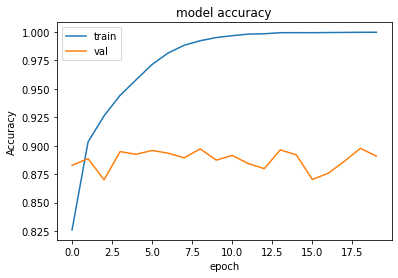

In [144]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.xticks(ticks=10)
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: ignored

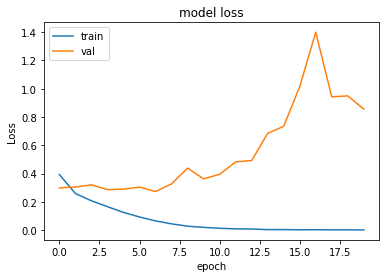

In [143]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.xticks(ticks=10)
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()